## 9 컴퓨터 비전을 위한 딥러닝

1 세가지 주요 컴퓨터 비전 작업 <br>
2 이미지 분할 예제 <br>
3 최신 컨브넷 아키텍처 패턴 <br>
4 컨브넷이 학습한 것 해석하기 <br>
5 요약 <br>


### 9.1 세가지 주요 컴퓨터 비전 작업

- 이미지 분류(image classification): <br>
    - 이미지에 하나 이상의 레이블을 할당하는 것이 목표 <br>
- 이미지 분할(image segmentation): <br>
    - 이미지를 다른 영역으로 '나누'거나 '분할'하는 것이 목표 <br>
- 객체 탐지(object detection): <br>
    - 이미지에 있는 관심 객체 주변에 bounding box라고 부르는 사각형을 그리는 것이 목표 <br>
- 그 외: <br>
    - 유사도 평가(image similarity scoring): 두 이미지가 시각적으로 얼마나 비슷한지 추정하기 <br>
    - 키포인트 감지(keypoint detection): 얼굴 특징과 같이 이미지에서 관심 속성을 정확히 짚어내기 <br>
    - 포즈 추정(pose estimation) <br>
    - 3D 메시 추정(mesh estimation) <br>
    
### 9.2 이미지 분할 예제
이미지 분할에는 2가지 종류가 있음 <br>
- Semantic Segmentation: <br>
    - 각 픽셀이 독립적으로 'cat'과 같은 하나의 의미를 가진 범주류 분류됨 <br>
- Instance Segmentation: <br>
    - 이미지 픽셀을 범주로 분류하는 것뿐안 아니라 개별 객체 인스터스를 구분한다 <br>

이 예제의 Oxford-IIIT pets 데이터셋은 분할 마스크 (segmenation task)를 포함하고 있음, 이미지 분할에서 레이블에 해당됨 <br>
분할 마스크의 픽셀은 3개의 정수 값 중 하나를 가진다. <br>
- 1(전경) <br>
- 2(배경) <br>
- 3(윤곽) <br>

In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

--2023-08-04 05:36:22--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2023-08-04 05:36:22--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-08-04 05:36:23--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

URL transformed to HTTPS due to an HSTS policy
--2023-08-04 05:37:01--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz [following]
--2023-08-04 05:37:01--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz [following]
--2023-08-04 05:37:02--  https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awa

In [5]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

입력 사진은 images/ 폴더에 JPG 파일로 저장되어 있음, 입력파일 경로와 분할 마스크 파일 경로를 각각 리스트로 구성해보자

In [1]:
import os

os.getcwd()

'/aiffel/aiffel/workplace/Aiffel_Quest/DeepLearningwithPython_2ndEdition'

In [2]:
input_dir = "./images/"
target_dir = "./annotations/trimaps/"

# print(input_dir)

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])

target_paths = sorted(
    [os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

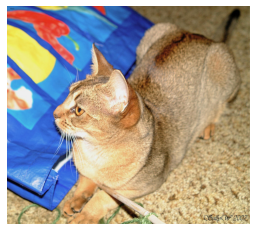

In [3]:
# 샘플 이미지 보기

import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))  # index 9에 해당하는 입력 이미지를 출력한다.

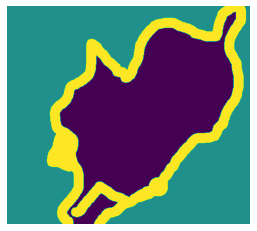

In [4]:
# 이에 해당하는 타깃(분할 마스크)은 다음과 같다. 

def display_target(target_array):
    normalized_array = (target_array.astype("uint8")-1)*127  
    # 원래 레이블은 1,2,3임. 여기서 1을 빼서 0~2범위로 만듦. 
    # 그 다음 127을 곱해서 레이블 값을 0 (검은색), 127(회색), 254(거의 힌색)로 만듦
    
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))  # color_made = "grayscale"로 지정하여 로드한 이미지를 하나의 컬러 채널이 있는 것처럼 다룸.
display_target(img)

그 다음 입력과 타깃을 2개의 넘파이 배열로 로드하고 이 배열을 훈련과 검증 세트로 나눔. 데이터셋이 매우 작기 떄문에 모두 메모리로 로드할 수 있음

In [5]:
import numpy as np
import random


img_size = (200, 200)  # 입력과 타깃을 모두 200*200 크기로 변경함
num_imgs = len(input_img_paths)  # 데이터에 있는 전체 샘플 개수

random.Random(1337).shuffle(input_img_paths)  # (원래 품종별로 정렬되어 있기 때문에) 파일 경로를 뒤섞는다.
random.Random(1337).shuffle(target_paths) # 입력 경로와 타깃 경로가 동일한 순서를 유지하도록 두 명령에 같은 시드(seed)(1337)를 사용

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))
def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8")-1  # 레이블이 0, 1, 2가 되도록 1을 뺀다.
    return img

input_imgs = np.zeros((num_imgs, ) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size+(1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])
    
num_val_samples = 1000   # 검증에 1000개의 샘플을 사용함

# 여기서부터는 데이터를 훈련 세트와 검증 세트로 나눈다. 
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]  

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape = img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)  
    # 입력 이미지를 [0-1]범위로 만드는 것을 잊지 마셈, 패딩이 특성 맵 크기에 영향을 미치지 않도록 모두 padding="same"으로 지정한다.
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
    # 각 출력 픽셀을 3개의 범주중 하나로 분류하기 위해 3개의 필터와 소프트맥스 활서화 함수를 가진 Conv2D층으로 모델을 종료함
    
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    
    model = keras.Model(inputs, outputs)
    return model


model = get_model(img_size = img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 256)       295168

3번 다운샘플링(downsampling)하여 마지막 합성곱 층의 활성화 출력은 (25, 25, 256)으로 끝난다.
합성곱 층마다 스트라이드(stride)를 추가하여 다운샘플링한다. 
이미지 분할의 경우 모델의 출력으로 픽셀별 타깃 마스크를 생성해야 하므로 정보의 공간상 위치에 많은 관심을 두기 때문, 
2*2 최대 풀링을 사용하면 풀링 윈도우 안의 위치 정보가 완전히 삭제, 윈도우마다 하나의 스칼라 값을 반환하며 이 값이 위도우 내의 네 위치 중 어디에서 왔는지 전혀 정보가 없음.
=> 따라서 최대 풀링은 분류 작업에는 잘 맞지만 분할 작업에는 상당한 해를 끼칠 수 있음.

In [7]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks=[
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]
history = model.fit(train_input_imgs, train_targets,
                   epochs=50,
                   callbacks=callbacks,
                   batch_size=64,
                   validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 [==============================] - 82s 694ms/step - loss: 1.0524 - val_loss: 0.9896
Epoch 2/50
100/100 [==============================] - 62s 623ms/step - loss: 0.9578 - val_loss: 0.9204
Epoch 3/50
100/100 [==============================] - 63s 628ms/step - loss: 0.8635 - val_loss: 0.7844
Epoch 4/50
100/100 [==============================] - 63s 632ms/step - loss: 0.7816 - val_loss: 0.7199
Epoch 5/50
100/100 [==============================] - 63s 631ms/step - loss: 0.7102 - val_loss: 0.6902
Epoch 6/50
100/100 [==============================] - 63s 630ms/step - loss: 0.6618 - val_loss: 0.6479
Epoch 7/50
100/100 [==============================] - 63s 631ms/step - loss: 0.6236 - val_loss: 0.5855
Epoch 8/50
100/100 [==============================] - 63s 631ms/step - loss: 0.5916 - val_loss: 0.5402
Epoch 9/50
100/100 [==============================] - 63s 632ms/step - loss: 0.5688 - val_loss: 0.5111
Epoch 10/50
100/100 [==============================] - 63s 630ms/step - l

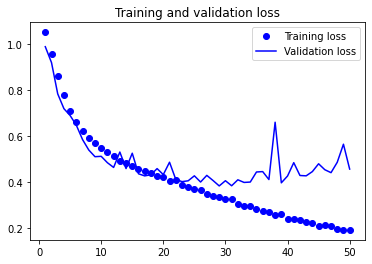

In [8]:
# 훈련과 검증 손실을 그래프로 나타내보겠음
epochs = range(1, len(history.history["loss"]) +1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

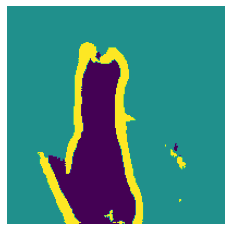

In [11]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i=4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):  # 모델 예측을 출력하기 위한 유틸리티 함수
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

이미지를 출력해 보면 전경과 배경에 있는 기하학적 모양 떄문에 예측된 마스크에 부수적으로 생긴 작은 흔적이 몇개 있음, 그럼에도 모델은 잘 동작하는 것 같음.


### 9.3 최선 컨브넷 아키텍처 패턴
- '아키텍처(architecture)'는 모델을 만드는 데 사용된 일련의 선택, 가설 공간(hypothesis space)인 사용할 층, 층의 설정, 층을 연결하는 방법등을 정의함 <br>
- 사전지식(prior knowledge)을 인코딩한다. <br>
- 모델 아키텍처가 성공과 실패를 가름하는 경우가 많음, 차선의 성능에 갇힐 수 있으며 많은 양의 훈련 데이터가 도움이 되지 않을 것 <br>
- 학습을 가속하고 모델이 훈련 데이터를 효율적으로 사용하게 만들어 대규모 데이터셋이 필요성을 줄여 듦 <br>
- 직관적 <br>
- 핵심적인 컨브넷 아키텍처의 모범 사례: 잔차 연결(residual connection), 배치 정규화(batch normalization), 분리 합성곱(separable convolution) <-- 이런 층을 사용하는 방법을 마스터하면 매우 효율적인 이미지 모델을 만들 수 있음 <br>
- 거시적인 관점에서 시스템 아키텍처에 대한 모듈화-계층화-재사용(Modulairy-Hierarchy-Resue, MHR) 공식을 보자 <br>

#### 9.3.1 모듈화, 계층화 그리고 재사용
- 복잡한 구조를 <b>모듈화(modularity)</b>하고, 모듈을 <b>계층화(hierarchy)</b>하고 같은 모듈을 적절하게 여려 곳에서 <b>재사용(reuse)</b>하는 것, 여기에서 재사용은 <b>추상화(abstraction)</b>의 다른말. 이것이 MHR(Modularity-Hierarchy-Resue)공식임. <br>
- 효율적인 코드는 모듈화되고 계층적이며 동일한 것을 2번 구현하지 않는다. 그 대신 재사용 가능한 클래스와 함수를 사용 <br>
- 딥러닝 자체는 경사 하강법을 통한 연속적이 최적화에 이런 방법을 적용한 것 뿐 <br>
- 모든 컨브넷 아키텍처는 층으로만 구성되어 있지 않고 반복되는 층 그룹('블록(block)' 또는 모듈(module)'이라고 부른다. <br>
- vanishing gradient 문제 때문에 층을 쌓을 수 있는 정도에 한계가 있음 => 잔차 열결을 탄생 <br><br>

__cf) 딥러닝 연구에서 절제 연구의 중요성__ <br>
연구의 목표는 단순히 논문 출판만이 아니라 신뢰할 수 있는 지식을 생성하는 것이어야 한다. 시스템에서 인과 관계(causality)를 이해하는 것이 신뢰할 수 있는 지식을 생성하는 가장 쉬운 방법=> 이게 바로 <b>절제연구(ablation study)</b><br>

<b>절제연구(ablation study)</b>란 체계적으로 시스템의 일부를 제거하여 단순하게 만들고 실제로 어디에서 성능 향상이 오는지 확인하는 것, X+Y+Z가 좋은 결과를 낸다면, X,Y,Z, X+Y, X+Z, Y+Z를 시도해 보고 어떤 일이 일어나는지 확인해 보자. <br>

<b>"더 간단하게 설명할 수 없을까? 추가된 복잡성이 정말 필요할까? 그렇다면 왜 필요할까?"</b>에 대한 끝없는 고민... <br>


#### 9.3.2 잔차 연결
함수연결이 너무 깊으면 이 잡음이 그레이티언트 정보를 압도하기 싲가하고 역전파가 동작하지 않게 된다. 즉, 모델이 전혀 훈련되지 않을 것이다.이를 vanishing gradient(그레이디언트 소실)문제라고 한다.
연결된 각 함수를 비파괴적으로 만들면 된다, 즉, 이전 입력에 담긴 잡음 없는 정보를 유지시킨다. 이를 구현하는 가장 쉬운 방법이 잔차 연결(residual connection)이다. 

#### 코드 9-1 잔차 연결 의사 코드

In [ ]:
x = ...  # 입력 텐서
residual = x   # 원본 입력을 별도로 저장한다, 이를 잔차라고 부른다.
x = block(x)  # 이 계산 블록은 파괴적이거나 잡음이 있을 수 있지만 괜춘
x = add([x, residual])  # 원본 입력을 층의 출력에 더한다. 따라서 최종 출력은 항상 원본 입력의 전체 정보를 보존한다. 

잔차를 원하는 출력 크기로 선형적으로 투영할 수 있다. 

#### 9-2 필터 개수가 변경되는 잔차 블록

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
residual = x  # 잔차를 따로 저장
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)  
# 잔차 블록에 해당하는 층, 이 층은 출력 필터를 32개에서 64개로 증가시킴,
# 패딩으로 인해 다운샘플링이 되지 않도록 padding="same"으로 지정
residual = layers.Conv2D(64, 1)(residual)  # 잔차는 32개의 필터만 있으므로 1*1 Conv2D를 사용하여 적절한 크기로 투영한다.
x = layers.add([x, residual])  # 이제 블록 출력과 잔차의 크기가 같으므로 더할 수 있다. 

#### 코드 9-3 최대 풀링 층을 가진 잔차 블록

In [14]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x    # 잔차를 따로 저장
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)  
# 이 잔차 블록은 2*2 최대 풀링 층을 포함하여 2개의 층으루 구성됨, 
# 패딩으로 인해 다운샘풀링이 되지 않도록 합성곱 층과 최대 풀링 층에 padding="same"을 지정
x = layers.MaxPooling2D(2, padding="same")(x)
residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])  # 이제 블록 출력과 잔차의 크기가 같으므로 더할 수 있다. 

다음 코드는 여러개의 블록으로 구성된 간단한 컨브넷의 예, 각 블록은 2개의 합성곱 층과 하나의 선택적인 최대 풀링층으로 이루어져 있고 각 블록마다 잔차 연결을 가진다.

In [15]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):  # 잔차 연결을 가진 합성곱 블록을 적용하는 utility 함수, 선택적으로 최대 풀링을 추가함
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
        # 최대 풀링을 사용하면 잔차를 원하는 크기로 투영하기 위해 스트라이드 합성곱을 추가함.
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)  # 최대 풀링을 사용하지 않으면 채널 수가 바뀐 경우에만 잔차를 투영함
    x = layers.add([x, residual])
    return x



x = residual_block(x, filters=32, pooling=True)  # 첫번째 블록
x = residual_block(x, filters=64, pooling=True)  # 두번째 블록, 블록마다 필터 개수가 증가함
x = residual_block(x, filters=128, pooling=False)  
# 마지막 블록은 바로 다음에 전역 평균 풀링(global average pooling)을 사용하기 때문에 최대 풀링이 필요하지 않는다. 



x = layers.GlobalAveragePooling2D()(x)
outputs= layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 32, 32, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 32, 32)   896         rescaling_1[0][0]                
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 32, 32, 32)   9248        conv2d_13[0][0]                  
____________________________________________________________________________________________

#### 9.3.3 배치 정규화

- 정규화는 머신 러닝 모델에 주입되는 샘플들을 균일하게 만드는 광범위한 방법 <br>
- 배치 정규화는 층의 한 종류(케라스는 BatchNormalization 클래스로 제공) <br>
- 훈련하는 동안 평균과 분산이 바뀌더라도 이에 적응하여 데이터를 정규화한다. 훈련하는 동안 현재 배치 데이터의 평균과 분산을 사용하여 샘플을 정규화한다. (대표성을 가질 만큼 충분히 큰 배치 데이터를 얻을 수 없는) 추론에서는 훈련에서 본 배치 데이터에서 구한 평균과 분산의 지수 이동 평균을 사용한다. <br>
- 내부 공변량 변화(internal covariate shift)를 감소시키기 때문 (이라고 하지만 배치 정규화가 왜 도움이 되는지 확실히 아는 사람은 없..)<br>
- 실제로 배치 정규화의 주요 효과는 잔차 연결과 매우 흡사하게 gradient의 전파를 도와주는 것 <br>

__cf) Dense층과 Conv2D층은 모두 편향 벡터를 가짐. 학습되는 이 변수는 층을 순수한 선형 변환이 아니라 아핀 변환으로 만드는 것__ <br>

- 일반적으로 활성화 층 이전에 배치 정규화층을 놓음 (<-- 아직 논란의 여지가 있음)

#### 코드 9-4 피해야 할 배치 정규화 사용법

In [16]:
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.BatchNormalization()(x)

# 결과를 보다시피 피해야한다

ValueError: Input 0 of layer conv2d_22 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 128)

#### 코드 9-5 배치 정규화 사용법: 활성화 층이 마지막에 온다

In [ ]:
x = layers.Conv2D(32, 3, use_bias=False)(x)   # 활성화 함수를 지정하지 않는다
x = layers.BatchNormalization()(x)
x = layers.Activation()(x)  # BatchNormalization층 다음에 활성화 층을 놓는다.

#### 9.3.4 깊이별 분리 합성곱

- Conv2D를 대체하면서 더 작고 (훈련할 모델 파라미터가 더 적고) 더 가볍고 (부동 소수점 연산이 더 적고) 모델의 성능을 몇 퍼센트 포인트 높일 수 있는 층이 있다면? <b> 깊이별 분리 합성곱(depthwise separable convolution) </b> 층이 하는 일. <br>
- 공간 특성의 학습과 채녈 방향 특성의 학습을 분리하는 효과: <br>
    - 합성곱이 이미지상의 패턴이 특정 위치에 묶여 있지 않다는 가정에 의존하는 것처럼, 깊이별 분류 합성곱은 중간 활성화에 있는 <b>공간상의 위치</b>가 <b>높은 상관관계</b>를 가지지만 채녈 간에는 <b> 매우 독립적 </b>이라는 가정에 의존 <br>
- 깊이별 분리 합성곱은 일반 합성곱보다 훨씬 적은 개수의 파라미터를 사용하고 더 적은 수의 연산을 수행하면서 유사한 표현 능력을 가지고 있다,
- 수렴이 더 빠르고 쉽게 과대적합되지 않는 작은 모델을 만듦, => 제한된 데이터로 밑바닥부터 작은 모델을 훈련할 때 특히 중요 <br>
↓ <br>
- 대규모 모델에 적용된 사례로는 케라스에 포함된 고성능 컨브넷인 Xception구조의 기반으로 깊이별 분리 합성곱이 사용 <br><br>

__cf) 하드웨어, 소프트웨어, 알고리즘의 공진화(co-evolution) ==> 딥러닝__
실전에서는 GPU를 사용할 듯,
NVIDIA와 GPU와 CUDA가 초기 역전파로 훈련되는 컨브넷의 성공을 이끌었고, 이런 알고리즘을 위해 NVIDIA가 하드웨어와 소프트웨어를 최적화하도록 만들었고, 결국 이런 방법을 사용하는 연구 커뮤니티를 통합시켰다. 이 시점에서 다른 방법을 찾으려며 전체 생태계를 수년간에 걸쳐 다시 설계해야 한다.

#### 9.3.5 Xception 유사 모델에 모두 적용하기
지금까지 배운 컨브넷 아키텍처 원칙을 정리하면 다음과 같다. <br>
- 모델은 반복되는 층인 <b>블록</b>으로 조직되어야 한다. 블록은 일반적으로 여러개의 합성곱 층과 최대 풀링 층으로 구성된다. <br>
- 특성 맵의 공간 방향 크기가 줄어듦에 따라 츠으이 필터 개수는 증가해야 한다. <br>
- 깊고 좁은 아키텍처가 넓고 얕은 것보다 낫다. <br>
- 층 블록에 잔차 연결을 추가하면 깊은 네트워크를 훈련하는데 도움이 된다. <br>
- 합성곱 층 다음에 배치 정규화 층을 추가하면 도움이 될 수 있다. <br>
- Conv2D 층을 파라미터 효율성이 더 좋은 SeparableConv2D층으로 바꾸면 도움이 될 수 있다. <br>
=> 이 아이디어를 하나의 모델에 적용해 보겠다. 

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)  # 데이터 증식 설정은 이전과 동일
x = layers.Rescaling(1./255)(x)  # 입력 데이터의 스케일 조정을 잊지 마셈
x = layers.Conv2D(filters =32, kernel_size=5, use_bias=False)(x)  
# 분리 합성곱의 이면에 있는 "특성 채널은 대체적으로 독립적이다"라는 가정은 RGB 이미지에는 맞지 않다,
# 빨간색, 녹색, 파란색 컬러 채널은 실제로 매우 높은 상관관계를 가진다. 따라서, 이 모델의 첫 번쨰 층은 일반적인 Conv2D이다.
# 그 다음부터 SeparableConv2D를 사용



# 특성 맵 깊이를 증가시키면서 합성곱 블록을 연속적으로 적용, 
# 각 블록은 배치 정규화 층을 적용한 2개의 깊이별 준리 합성곱 층과 하나의 최대 풀링층으로 구성됨
# 블록마다 잔차 연결이 추가됨

for size in [32, 64, 128, 256, 512]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_biase=False)(x)
    
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    
    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])   
    
    x = layers.GlobalAveragePooling2D()(x)   
    # 원래 모델에서는 Dense층 이전에 Flatten층을 사용함, 
    # 여기에서는 GlobalAveragePooling2D층을 사용함
    
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)